In [133]:
import os
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sdv.metadata import SingleTableMetadata
from sdv.single_table import CTGANSynthesizer as CTGAN, TVAESynthesizer as TVAE
from sdv.sampling import Condition
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.utils import to_categorical
from utils import manage_outlier

def seed_everything(seed:int=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

warnings.filterwarnings('ignore')
seed_everything()

In [97]:
df = pd.read_csv('./dataset/ff.csv')

def make_targets(targets):
    return 1 if targets >=5 else 0

df['BE5_1'] = df.apply(
    lambda row: make_targets(row['BE5_1']), axis=1
)
drops = df.isna().sum().sort_values(ascending=False) / df.shape[0] * 100
df = df[drops[drops.values <= 10].index]
# feature importance 기반 변수 제거(1차)
df.drop(['LQ_1EQL', 'LQ_2EQL', 'LQ_3EQL', 'LQ_4EQL', 'LQ_5EQL'], axis=1, inplace=True)
# corr matrix 기반 변수 제거(2차)
df.drop(['EC1_1'], axis=1, inplace=True)
# feature importance 기반 변수 제거(3차)
df.drop(['cage', 'LQ1_sb', 'LQ1_mn', 'LQ4_00'], axis=1, inplace=True)
# feture importance 기반 변수 제거(4차)
df.drop(['BD1', 'mh_stress', 'BS3_1'], axis=1, inplace=True)
# feture importance 기반 변수 제거(5차)
df.drop(['BO1_1', 'BO2_1'], axis=1, inplace=True)

In [98]:
# 1차년도
NUMERIC = ['HE_FEV1FVC', 'age', 'Total_slp_wk']
CATEGORICAL = ['sex', 'occp', 'EC1_1', 'cfam', 'marri_1', 'BH9_11', 'HE_DM', 'DC6_dg', 'DF2_dg', 'HE_HPdg', 'BP5']
ONE_HOT = ['BS3_1', 'edu', 'BP1', 'D_1_1', 'LQ_1EQL', 'LQ_2EQL', 'LQ_3EQL', 'LQ_4EQL', 'LQ_5EQL', 'BO1_1', 'BO2_1']
# 2차년도
NUMERIC2 = ['DI1_ag', 'DE1_ag', 'LQ1_mn', 'BS6_2_1', 'BS6_3']
CATEGORICAL2 = ['DI1_pt', 'DE1_pt', 'DE1_3', 'BH1', 'BH2_61', 'LQ4_00', 'LQ4_05', 'LQ1_sb', 'MO1_wk', 'HE_cough1', 'HE_sput1', 'BD1', 'BD7_5', 'BP6_10', 'BP6_31']
ONE_HOT2 = ['DI1_2', 'EC_pedu_1', 'EC_pedu_2', 'BS5_1', 'BD7_4']
# 생성변수
NUMERIC3 = ['eq_5d']
CATEGORICAL3 = ['sm_present', 'mh_stress']
ONE_HOT3 = ['cage']
# Targets
TARGETS = ['BE3_31', 'BE5_1']

f_NUMERIC = (NUMERIC + NUMERIC2 + NUMERIC3).copy()
f_CATEGORICAL = (CATEGORICAL + CATEGORICAL2 + CATEGORICAL3).copy()
f_ONE_HOT = (ONE_HOT + ONE_HOT2 + ONE_HOT3).copy()
f_CATEGORICAL.append('BE3_31')

In [104]:
for value in f_NUMERIC:
    if value not in df.columns:
        print(value)
        f_NUMERIC.remove(value)

for value in f_CATEGORICAL:
    if value not in df.columns:
        print(value)
        f_CATEGORICAL.remove(value)

for value in f_ONE_HOT:
    if value not in df.columns:
        print(value)
        f_ONE_HOT.remove(value)

In [105]:
# 결측치 처리
for col in f_NUMERIC:
    df[col].fillna(0, inplace=True)
for col in f_CATEGORICAL:
    df[col].fillna(0, inplace=True)
for col in f_ONE_HOT:
    df[col].fillna(df[col].mode()[0], inplace=True)

In [106]:
# 이상치 제거
for col in f_NUMERIC:
    print(col)
    manage_outlier(df, col)

HE_FEV1FVC
245개 삭제
age
0개 삭제
Total_slp_wk
28개 삭제
BS6_2_1
49개 삭제
BS6_3
220개 삭제
eq_5d
141개 삭제


In [108]:
X = df.drop('BE5_1', axis=1)
y = df['BE5_1']

X_numeric = X[f_NUMERIC]
X_categorical = X[f_CATEGORICAL]
X_onehot = X[f_ONE_HOT]
X_onehot = pd.get_dummies(X_onehot, dtype=float)

X = pd.concat([X_numeric, X_categorical], axis=1)
X = pd.concat([X, X_onehot], axis=1)
# split
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=.2, stratify=y, random_state=42)

scaler = StandardScaler()
train_X[f_NUMERIC] = scaler.fit_transform(train_X[f_NUMERIC])

test_X[f_NUMERIC] = scaler.transform(test_X[f_NUMERIC])

In [109]:
counts = np.bincount(train_y)
print(
    "Number of positive samples in training data: {} ({:.2f}% of total)".format(
        counts[1], 100 * float(counts[1]) / len(train_y)
    )
)

weight_for_0 = 1.0 / counts[0]
weight_for_1 = 1.0 / counts[1]

Number of positive samples in training data: 272 (11.00% of total)


In [110]:
smote = SMOTE(random_state=42)
sm_X, sm_y = smote.fit_resample(train_X, train_y)
counts = np.bincount(sm_y)
print(
    "Number of positive samples in smote(oversampling) data: {} ({:.2f}% of total)".format(
        counts[1], 100 * float(counts[1]) / len(sm_y)
    )
)

weight_for_0 = 1.0 / counts[0]
weight_for_1 = 1.0 / counts[1]

Number of positive samples in smote(oversampling) data: 2201 (50.00% of total)


In [158]:
meta = train_X.copy()
meta['BE5_1'] = train_y

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=meta)

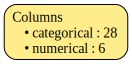

In [159]:
metadata.visualize(
    show_table_details='summarized',
    output_filepath='my_metadata.png'
)

In [160]:
ctgan = CTGAN(metadata, verbose=True)
ctgan.fit(meta)

Gen. (-1.10) | Discrim. (0.31):  35%|███▍      | 104/300 [00:33<01:03,  3.07it/s] 

In [ ]:
tvae = TVAE(metadata)
tvae.fit(meta)

In [143]:
condition = Condition(
    num_rows=2000,
    column_values={'BE5_1':1}
)

In [147]:
ctgan_sample = ctgan.sample_from_conditions(
    conditions=[condition]
)

Sampling conditions: 100%|██████████| 2000/2000 [00:02<00:00, 853.51it/s]


In [148]:
tvae_sample = tvae.sample_from_conditions(
    conditions=[condition]
)

Sampling conditions: 100%|██████████| 2000/2000 [00:03<00:00, 623.92it/s]


In [151]:
ctgan_X = train_X.copy()
ctgan_y = train_y.copy()
ctgan_X = ctgan_X.reset_index().drop('index', axis=1)
ctgan_y = ctgan_y.reset_index().drop('index', axis=1)

In [157]:
# ctgan_X = pd.concat([ctgan_X, ctgan_sample.drop('Target', axis=1)])
pd.concat([ctgan_y, ctgan_sample[['Target']]])

,BE5_1,Target
0,0.0,NaN
1,0.0,NaN
2,0.0,NaN
3,0.0,NaN
4,0.0,NaN
...,...,...
1995,NaN,1.0
1996,NaN,1.0
1997,NaN,1.0
1998,NaN,1.0


In [69]:
print(f'train shape: {train_X.shape, train_y.shape}')
print(f'train(over) shape: {sm_X.shape, sm_y.shape}')
print(f'test shape: {test_X.shape, test_y.shape}')

train shape: ((2473, 33), (2473,))
train(over) shape: ((4402, 33), (4402,))
test shape: ((619, 33), (619,))


In [150]:
train_X

,HE_FEV1FVC,age,Total_slp_wk,BS6_2_1,BS6_3,eq_5d,sex,occp,cfam,marri_1,...,D_1_1_나쁨,D_1_1_매우나쁨,D_1_1_매우좋음,D_1_1_보통,D_1_1_좋음,BS5_1_1개월내금연,BS5_1_6개월내금연,BS5_1_금연안함,BS5_1_비흡연자,BS5_1_언젠가금연
1749,0.831488,-1.736795,-0.464230,0.852411,2.001970,0.697283,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1266,1.089618,1.404731,-0.464230,0.852411,0.700137,0.697283,1.0,0.0,2.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3446,0.690606,-0.375467,-1.176413,-0.569616,-0.601697,0.697283,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2674,0.551078,0.881143,0.960138,-0.569616,-0.601697,-2.075406,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2600,0.925353,1.195296,-0.464230,-0.356312,2.001970,0.697283,1.0,0.0,2.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3375,0.955147,-1.317925,-1.888597,-0.569616,-0.601697,-0.915516,1.0,1.0,5.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
251,0.773998,-1.632077,-0.464230,-0.569616,-0.601697,-0.738771,1.0,1.0,6.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1258,1.125194,0.148120,1.672321,-0.569616,-0.601697,0.697283,0.0,0.0,6.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1443,0.168783,0.776426,0.960138,-0.569616,-0.601697,-1.887614,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [70]:
model = keras.Sequential(
    [
        keras.Input(shape=train_X.shape[1:]),
        keras.layers.Dense(512),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(256),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dense(2, activation="softmax"),
    ]
)
metrics = [
    # keras.metrics.FalseNegatives(name="fn"),
    # keras.metrics.FalsePositives(name="fp"),
    # keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.TruePositives(name="tp"),
    # keras.metrics.Precision(name="precision"),
    # keras.metrics.Recall(name="recall"),
    keras.metrics.CategoricalAccuracy(name="acc"),
    # keras.metrics.CategoricalAccuracy(name="cacc"),
    keras.metrics.AUC(name="auc"),
    tfa.metrics.F1Score(num_classes=2, name='f1', average='macro')
]
loss = keras.losses.CategoricalFocalCrossentropy()
model.compile(
    optimizer=keras.optimizers.AdamW(1e-4), loss=loss, metrics=metrics
)
callback = keras.callbacks.ModelCheckpoint('./auto.h5', mode='max', monitor='val_f1', save_best_only=True)
class_weight = {0: weight_for_0, 1: weight_for_1}

In [73]:
hist = model.fit(
    train_X,
    to_categorical(train_y),
    batch_size=256,
    epochs=120,
    validation_data=(test_X, to_categorical(test_y)),
    class_weight=class_weight,
    callbacks=[callback]
)

Epoch 1/120
10/10 [==============================] - 0s 17ms/step - loss: 2.6064e-05 - tp: 1798.0000 - acc: 0.7271 - auc: 0.8249 - f1: 0.6062 - val_loss: 0.0359 - val_tp: 429.0000 - val_acc: 0.6931 - val_auc: 0.7798 - val_f1: 0.5701
Epoch 2/120
10/10 [==============================] - 0s 11ms/step - loss: 2.6281e-05 - tp: 1806.0000 - acc: 0.7303 - auc: 0.8218 - f1: 0.6068 - val_loss: 0.0361 - val_tp: 425.0000 - val_acc: 0.6866 - val_auc: 0.7761 - val_f1: 0.5632
Epoch 3/120
10/10 [==============================] - 0s 11ms/step - loss: 2.7435e-05 - tp: 1757.0000 - acc: 0.7105 - auc: 0.8060 - f1: 0.5919 - val_loss: 0.0371 - val_tp: 418.0000 - val_acc: 0.6753 - val_auc: 0.7608 - val_f1: 0.5569
Epoch 4/120
10/10 [==============================] - 0s 11ms/step - loss: 2.6824e-05 - tp: 1745.0000 - acc: 0.7056 - auc: 0.7942 - f1: 0.5871 - val_loss: 0.0370 - val_tp: 417.0000 - val_acc: 0.6737 - val_auc: 0.7613 - val_f1: 0.5557
Epoch 5/120
10/10 [==============================] - 0s 11ms/step - 

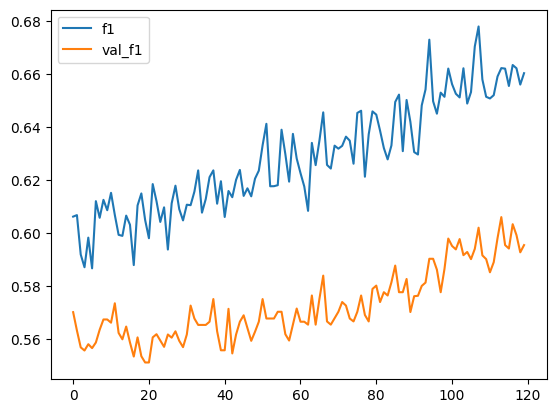

In [74]:
plt.plot(hist.history['f1'])
plt.plot(hist.history['val_f1'])
plt.legend(['f1', 'val_f1'])

In [75]:
md = keras.models.load_model('./auto.h5')
pred = md.predict(train_X)
print(classification_report(train_y, tf.argmax(pred, axis=1)))

78/78 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       1.00      0.78      0.88      2201
           1       0.36      1.00      0.53       272

    accuracy                           0.80      2473
   macro avg       0.68      0.89      0.70      2473
weighted avg       0.93      0.80      0.84      2473



In [84]:
np.where(pred[:, 0]>.5, 0, 1)

array([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,

In [93]:
md = keras.models.load_model('./auto.h5')
pred = md.predict(test_X)
pred2 = np.where(pred[:, 0]>.4, 0, 1)
# print(classification_report(test_y, tf.argmax(pred, axis=1)))
print(classification_report(test_y, pred2))


20/20 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       551
           1       0.33      0.34      0.34        68

    accuracy                           0.85       619
   macro avg       0.63      0.63      0.63       619
weighted avg       0.85      0.85      0.85       619



In [31]:
# pred = model.predict(train_X)
# pred = np.squeeze(np.where(model.predict(train_X) >= .5, 1, 0))
pred = model.predict(test_X)
print(classification_report(tf.argmax(pred, axis=1), test_y))
# print(classification_report(pred, train_y))

 1/24 [>.............................] - ETA: 0s

24/24 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.94      0.91      0.92       701
           1       0.20      0.31      0.25        54

    accuracy                           0.86       755
   macro avg       0.57      0.61      0.59       755
weighted avg       0.89      0.86      0.88       755



<Axes: >

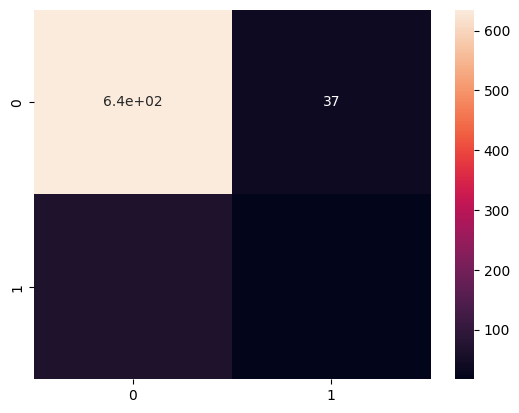

In [33]:
sns.heatmap(confusion_matrix(test_y, tf.argmax(pred, axis=1)), annot=True)

In [98]:
# pred = model.predict(val_X)
pred = np.squeeze(np.where(model.predict(val_X) >= .5, 1, 0))
# print(classification_report(tf.argmax(pred, axis=1), val_y))
print(classification_report(pred, val_y))

19/19 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.72      0.91      0.81       419
           1       0.44      0.16      0.24       176

    accuracy                           0.69       595
   macro avg       0.58      0.54      0.52       595
weighted avg       0.64      0.69      0.64       595



In [99]:
# pred = model.predict(test_X)
pred = np.squeeze(np.where(model.predict(test_X) >= .5, 1, 0))
# print(classification_report(tf.argmax(pred, axis=1), test_y))
print(classification_report(pred, test_y))

5/5 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       0.63      0.93      0.75        89
           1       0.65      0.18      0.29        60

    accuracy                           0.63       149
   macro avg       0.64      0.56      0.52       149
weighted avg       0.64      0.63      0.56       149



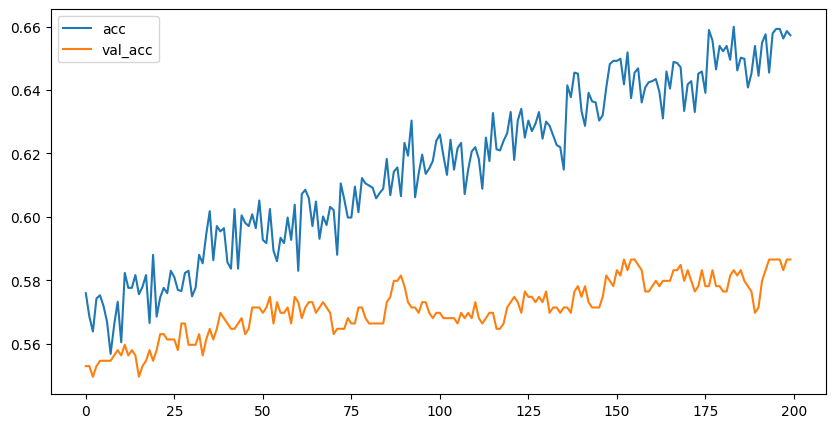

In [91]:
plt.figure(figsize=(10, 5))
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.legend(['acc', 'val_acc'])

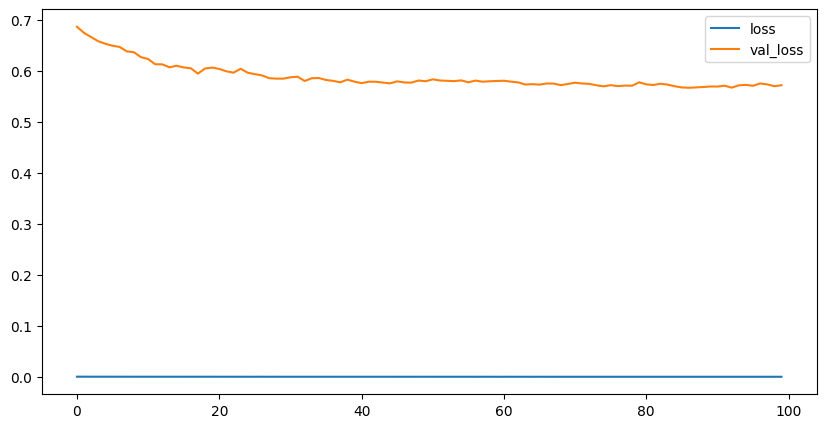

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['loss', 'val_loss'])